In [1]:
%pip install --extra-index-url https://artefact.skao.int/repository/pypi-internal/simple \
  git+https://gitlab.com/ska-telescope/ska-low-csp-test  # for visibility unpacking and plotting

Looking in indexes: https://pypi.org/simple, https://artefact.skao.int/repository/pypi-internal/simple
  Cloning https://gitlab.com/ska-telescope/ska-low-csp-test to /tmp/pip-req-build-d5deyt_c
  Running command git clone --filter=blob:none --quiet https://gitlab.com/ska-telescope/ska-low-csp-test /tmp/pip-req-build-d5deyt_c
  Resolved https://gitlab.com/ska-telescope/ska-low-csp-test to commit d0ec60108aaeaef4ef8d74c01aeae7612685fb24
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
from ska_low_csp_test.cbf import visibilities
from ska_low_csp_test.domain import plotting
from ska_low_csp_test.cbf.visibilities import Polarization
from PIL import Image
from matplotlib import pyplot as plt
from io import BytesIO

## Read data file

In [3]:
filename = "/mnt/clp-k8s-fpga-worker-1/pcap/output/config-2024-07-01T10-14-04.610761_scan-1.pcap"
filename = "/mnt/clp-k8s-fpga-worker-1/pcap/output/config-2024-07-07T19-55-56.118889_scan-1.pcap"
print(filename)

/mnt/clp-k8s-fpga-worker-1/pcap/output/config-2024-07-07T19-55-56.118889_scan-1.pcap


In [4]:
pcap_output = visibilities.unpack_pcap_file(filename)

In [5]:
pcap_output.metadata

ScaID  Chann  Epoch  ZoomI  Resol SrcID  BeaID  Subar  Firmw  Basel  \
0          1      0      0      0     32  b'L'      1      1   1792     10   
1          1      1      0      0     32  b'L'      1      1   1792     10   
2          1      2      0      0     32  b'L'      1      1   1792     10   
3          1      3      0      0     32  b'L'      1      1   1792     10   
4          1      4      0      0     32  b'L'      1      1   1792     10   
...      ...    ...    ...    ...    ...   ...    ...    ...    ...    ...   
13819      1  13819      0      0     32  b'L'      1      1   1792     10   
13820      1  13820      0      0     32  b'L'      1      1   1792     10   
13821      1  13821      0      0     32  b'L'      1      1   1792     10   
13822      1  13822      0      0     32  b'L'      1      1   1792     10   
13823      1  13823      0      0     32  b'L'      1      1   1792     10   

          Integ        Frequ      Hardw      FreHz  
0      0.849347  5425.347168  890199240  162111975  
1      0.849347  5425.347168  890199240  162117400  
2      0.849347  5425.347168  890199240  162122825  
3      0.849347  5425.347168  890199240  162128251  
4      0.849347  5425.347168  890199240  162133676  
...         ...          ...        ...        ...  
13819  0.849347  5425.347168  890199240  237084848  
13820  0.849347  5425.347168  890199240  237090273  
13821  0.849347  5425.347168  890199240  237095699  
13822  0.849347  5425.347168  890199240  237101124  
13823  0.849347  5425.347168  890199240  237106549  

[13824 rows x 14 columns]

In [6]:
pcap_output.data

<xarray.Dataset> Size: 478MB
Dimensions:             (channel_id: 13824, baseline: 10, polarization: 4,
                         epoch_offset: 108)
Coordinates:
  * channel_id          (channel_id) int64 111kB 0 1 2 3 ... 13821 13822 13823
  * baseline            (baseline) <U6 240B '(0, 0)' '(1, 0)' ... '(3, 3)'
  * polarization        (polarization) <U2 32B 'XX' 'XY' 'YX' 'YY'
  * epoch_offset        (epoch_offset) uint64 864B 773697429431008200 ... 773...
    scan_id             (epoch_offset) uint64 864B 1 1 1 1 1 1 1 ... 1 1 1 1 1 1
Data variables: (12/108)
    773697429431008200  (channel_id, baseline, polarization) complex64 4MB (9...
    773697430280354760  (channel_id, baseline, polarization) complex64 4MB (9...
    773697431129701320  (channel_id, baseline, polarization) complex64 4MB (9...
    773697431979047880  (channel_id, baseline, polarization) complex64 4MB (9...
    773697432828394440  (channel_id, baseline, polarization) complex64 4MB (9...
    773697433677741000  (channel_id, baseline, polarization) complex64 4MB (9...
    ...                  ...
    773697516064357320  (channel_id, baseline, polarization) complex64 4MB (9...
    773697516913703880  (channel_id, baseline, polarization) complex64 4MB (9...
    773697517763050440  (channel_id, baseline, polarization) complex64 4MB (9...
    773697518612397000  (channel_id, baseline, polarization) complex64 4MB (9...
    773697519461743560  (channel_id, baseline, polarization) complex64 4MB (9...
    773697520311090120  (channel_id, baseline, polarization) complex64 4MB (9...
Attributes:
    baselines_auto_idx:   [0, 2, 5, 9]
    baselines_cross_idx:  [1, 3, 4, 6, 7, 8]

## Unpack the data

In [7]:
VIS = pcap_output.data.to_array(dim="epoch_offset")

auto_corr_bls = VIS.baselines_auto_idx
cross_corr_bls = VIS.baselines_cross_idx

In [8]:
import xarray as xr
import numpy as np
from datetime import datetime, timezone
import matplotlib.pylab as plt

In [9]:
# how many scan ids
scan_ids = np.unique(VIS.scan_id.data)
# get epoch offset
epoch_offset = VIS.epoch_offset.data / 1e9
# channels
channels = VIS.channel_id.data

In [10]:
[n_ts, n_chan, n_bl, n_corr] = VIS.shape
n_stations = int((-1 + np.sqrt(1+8*n_bl))/2)
station_ids = [345, 350, 352, 431]
if n_stations != len(station_ids):
    raise RuntimeError("Single baseline test {station_ids} has baselines for {n_stations}")
# assuming baseline order as per perentie notebooks
bls = np.arange((n_stations*(n_stations+1))//2)
bl_lookup = np.empty([len(bls), 2], dtype="i4")
bl_idx=0
for A in range(0, n_stations):
    for B in range(0, A+1):
        bl_lookup[bl_idx] = [station_ids[A], station_ids[B]]
        bl_idx +=1

print(bl_lookup)

[[345 345]
 [350 345]
 [350 350]
 [352 345]
 [352 350]
 [352 352]
 [431 345]
 [431 350]
 [431 352]
 [431 431]]


## Plotting utility functions


In [11]:
def fit_trend(xvalues, yvalues):
    # Fit the trend line.
    (m, b), (SSE,), *_ = np.polyfit(xvalues, yvalues, deg=1, full=True)
    return m, b

def subplot_(hndl, xvalues, yvalues, corr_, label_, set_xticks=False, show_vlines=False):
    line_idx = None
    amplitude = np.abs(yvalues)
    phase = np.angle(yvalues)
    
    if len(xvalues) < 20:
        xticks_vals = xvalues
    else:
        step = int(len(xvalues)/20)
        xticks_vals = xvalues[::step]
    
    hndl[0].plot(xvalues, amplitude, ".--")
    if show_vlines:
        line_idx = (-amplitude).argsort()[:3]
        for line in line_idx: hndl[0].axvline(x=xvalues[line], color='y', linestyle="--")
    hndl[0].set_ylabel(f'{corr_} Amplitude [arb]')
    hndl[0].set_xticks(xticks_vals)
    hndl[0].set_xticklabels(hndl[0].get_xticklabels(), rotation=45)        

    hndl[1].plot(xvalues, phase, "*-", label=label_)
    hndl[1].set_ylabel(f'{corr_} Phase [arb]')
    hndl[1].set_ylim([-np.pi, np.pi])
    hndl[1].set_xticks(xticks_vals)
    hndl[1].set_xticklabels(hndl[1].get_xticklabels(), rotation=45)        
    hndl[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    return line_idx
    
def get_scan(VIS, scan_id):
    return VIS[VIS.scan_id == scan_id]
def get_scan_mask(VIS, scan_id):
    return [VIS.scan_id == scan_id][0].data

## Inspect the data


In [12]:
# for plots over time, normalise all timestamps to be the number of milliseconds from start of scan
timestamps = (epoch_offset-epoch_offset[0])*1e3

print(f"Total execution run {(timestamps[-1]-timestamps[0])/1e3} seconds")
for scan_id in scan_ids:
    scan_epoch_mask = get_scan_mask(VIS, scan_id)
    ts = timestamps[scan_epoch_mask]
    print(f" Scan {scan_id} execution time {(ts[-1]-ts[0])/1e3} seconds")

Total execution run 90.88008201122284 seconds
 Scan 1 execution time 90.88008201122284 seconds


### Autocorrelation amp and phase over time

In [13]:
def plot_over_time(ts, data, scan_id, bls, bl_lookup, overplot=False):
    [n_ts, n_bls, n_corrs] = data.shape
    if overplot:
        fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25, 12))
    for bl_idx in bls:
        if not overplot:
            fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25, 12))
        label=f"bl {bl_idx} {bl_lookup[bl_idx]}"
        for ax_idx, corr_ in enumerate(["XX","XY","YX","YY"]):
            subplot_(axes[ax_idx], ts, data[:,bl_idx,ax_idx], corr_, label)
            axes[ax_idx][0].set_xlabel("Time (ms) since start")
            axes[ax_idx][1].set_xlabel("Time (ms) since start")

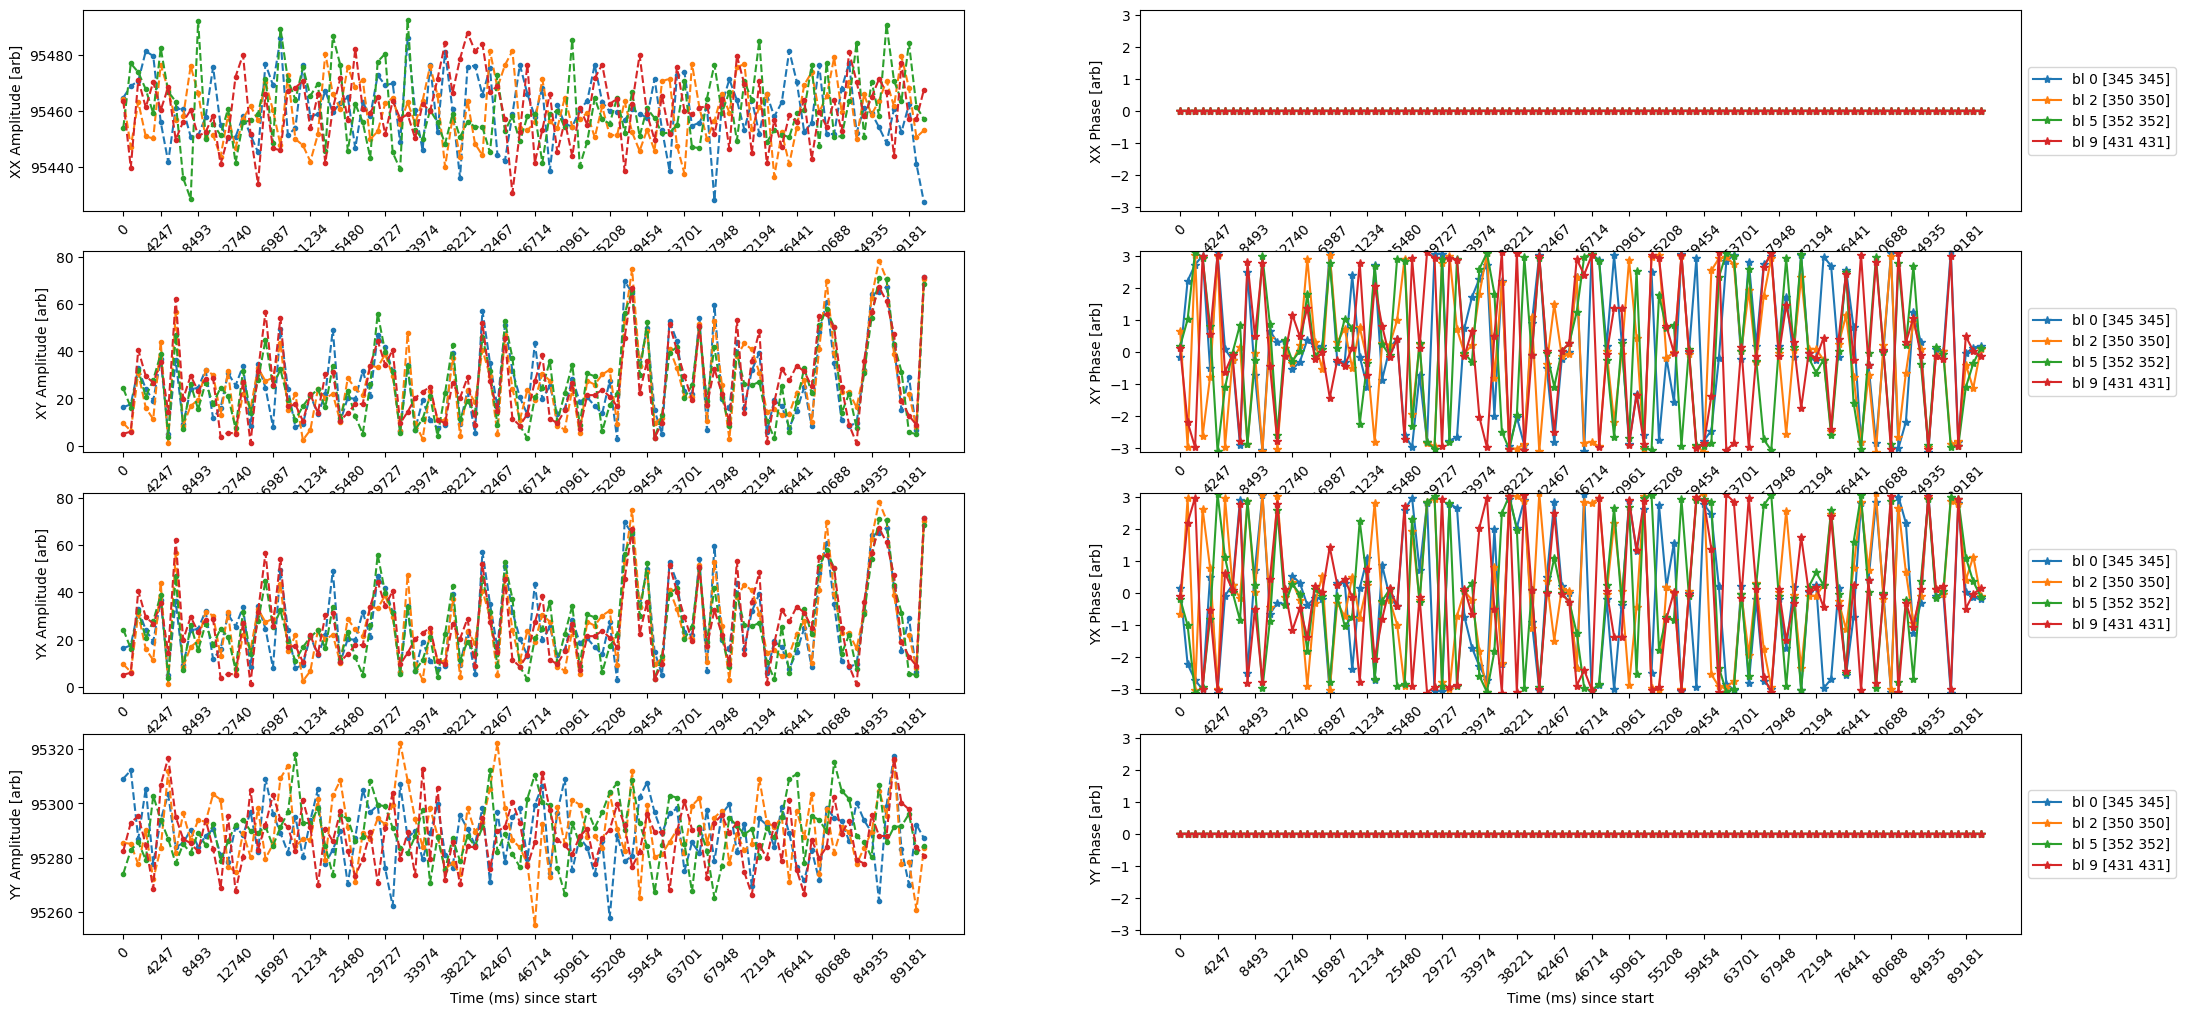

In [15]:
for scan_id in scan_ids:
    scan_samples = get_scan(VIS, scan_id)
    scan_epoch_mask = get_scan_mask(VIS, scan_id)
    scan_times = [datetime.fromtimestamp(ts, timezone.utc) for ts in timestamps[scan_epoch_mask]]
    # show over all timestamps
    # plot_over_time(timestamps[scan_epoch_mask], scan_samples.data.mean(axis=1), scan_id, auto_corr_bls, bl_lookup, overplot=True)
    plot_over_time(timestamps[scan_epoch_mask], np.nanmean(scan_samples.data, axis=1), scan_id, auto_corr_bls, bl_lookup, overplot=True)
    
    # ignore timestamps that show outliers
    #plot_over_time(timestamps[scan_epoch_mask][3:], scan_samples.data.mean(axis=1)[3:], scan_id, auto_corr_bls, bl_lookup, overplot=True)

In [16]:
def plot_over_channel(chans, data, scan_id, bls, bl_lookup):
    [n_chans, n_bls, n_corrs] = data.shape
    for cnt, bl_idx in enumerate(bls):
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25, 15))
        label=f"scan {scan_id} bl {bl_idx} {bl_lookup[bl_idx]}"
        plt_cnt = 0
        for ax_idx, corr_ in enumerate(["XX","XY","YX","YY"]):
            show_vlines = False
            if corr_ == "XY" or corr_ == "YX": continue
            yvalues = data[:,bl_idx,ax_idx]
            if corr_ == "XX": show_vlines = True
            line_idx = subplot_(axes[plt_cnt], chans, yvalues, corr_, label, show_vlines=show_vlines)
            if line_idx is not None:
                line_idx.sort()
                axes[plt_cnt][0].set_title(f"chan {line_idx} = freq {chans[line_idx]} MHz")
            axes[plt_cnt][0].set_xlabel("Frequency [MHz]")
            axes[plt_cnt][1].set_xlabel("Frequency [MHz]")
            plt_cnt += 1

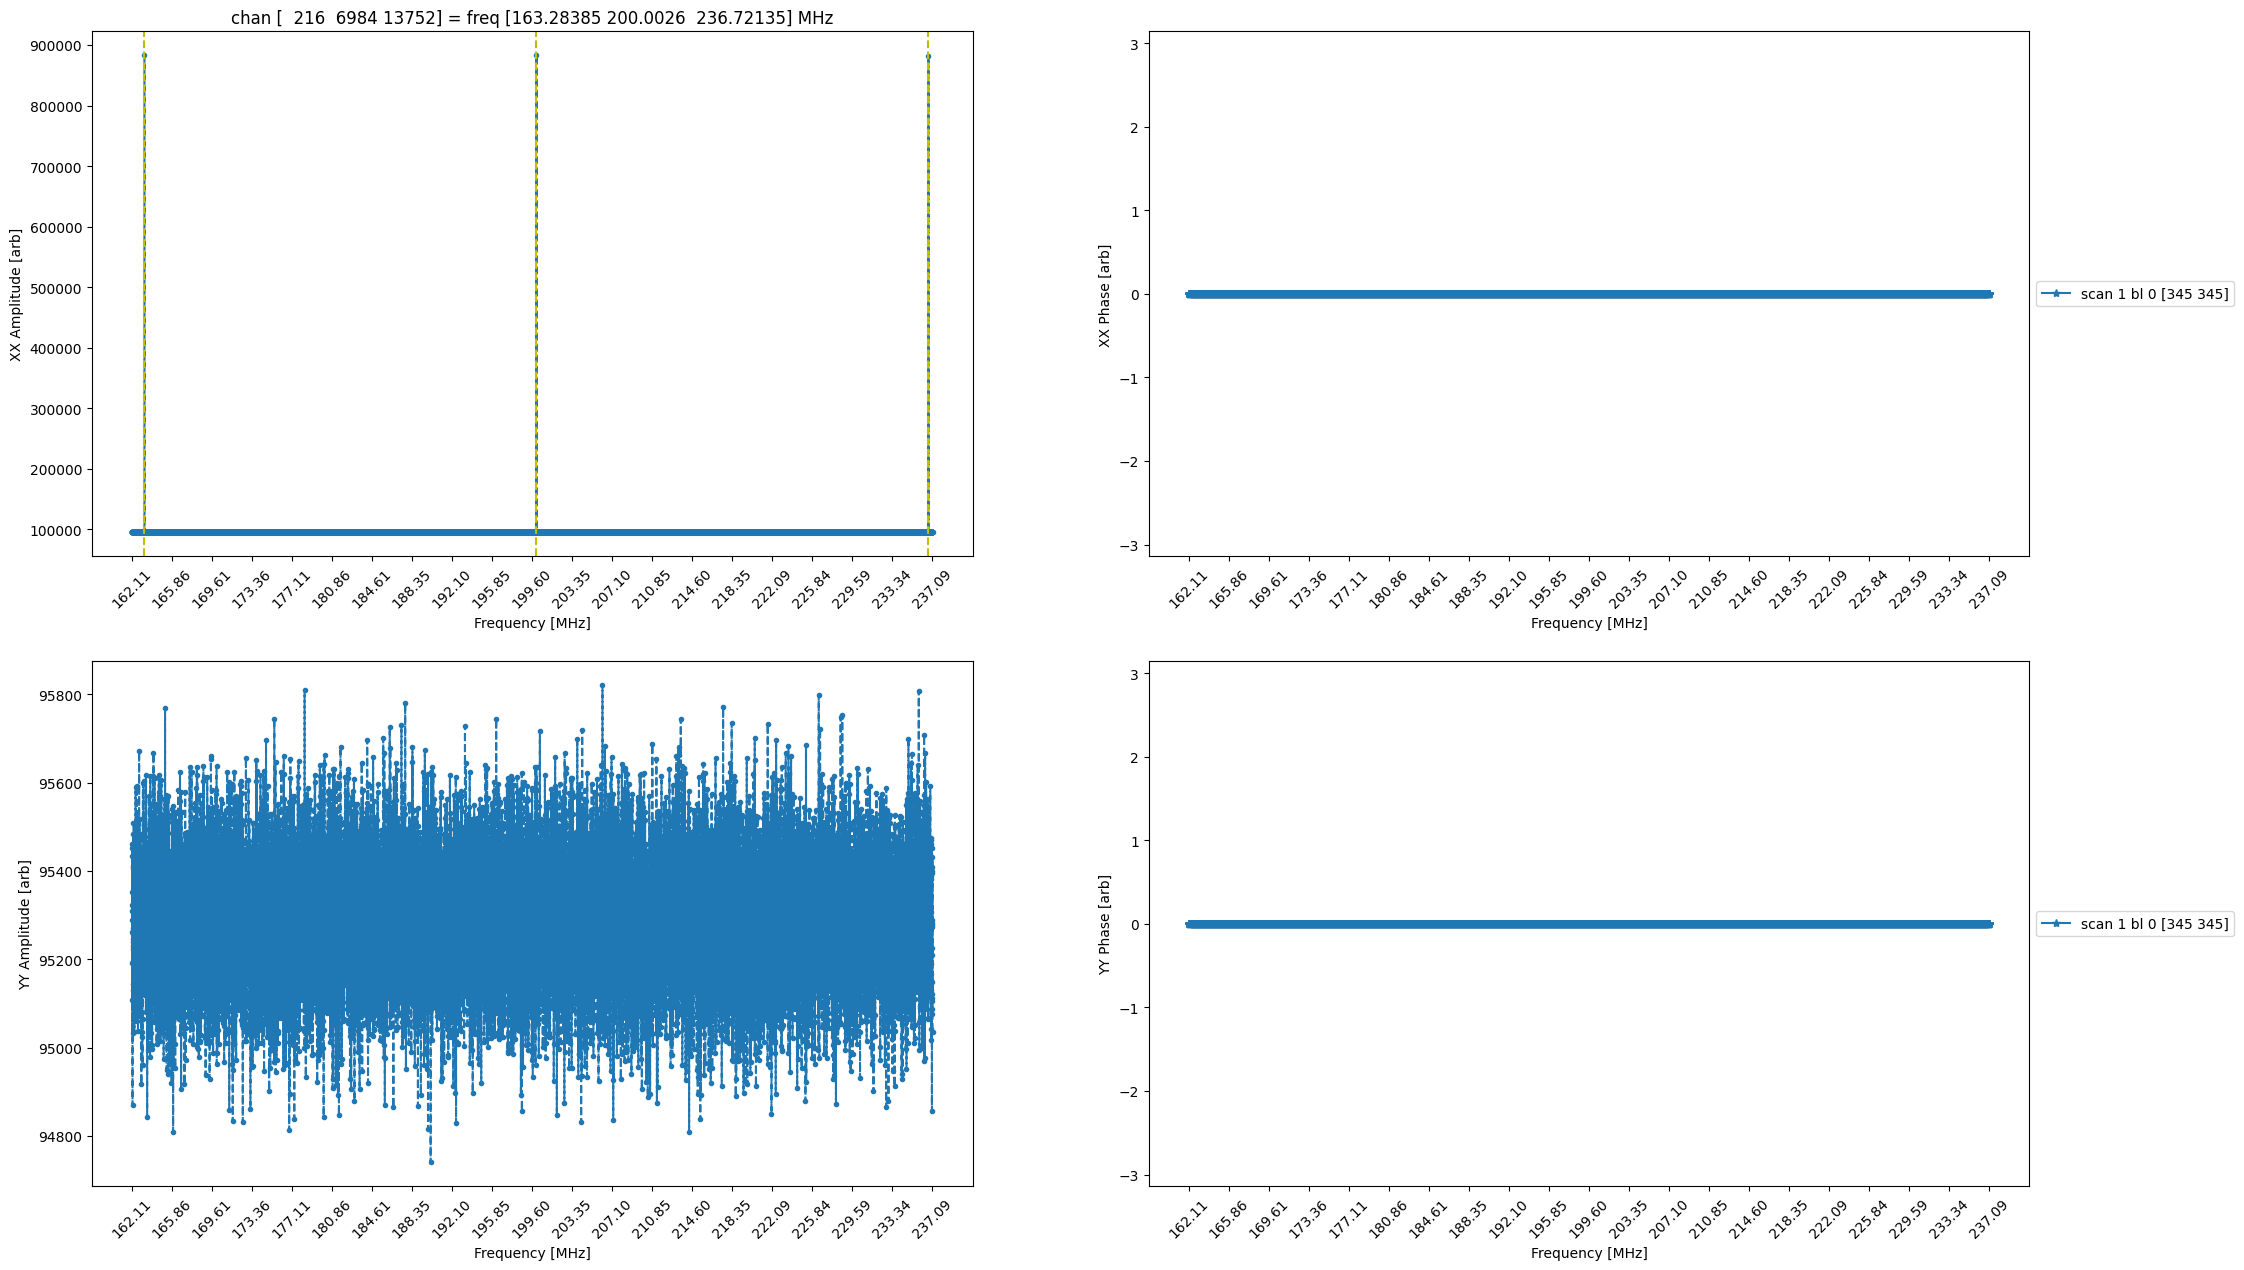

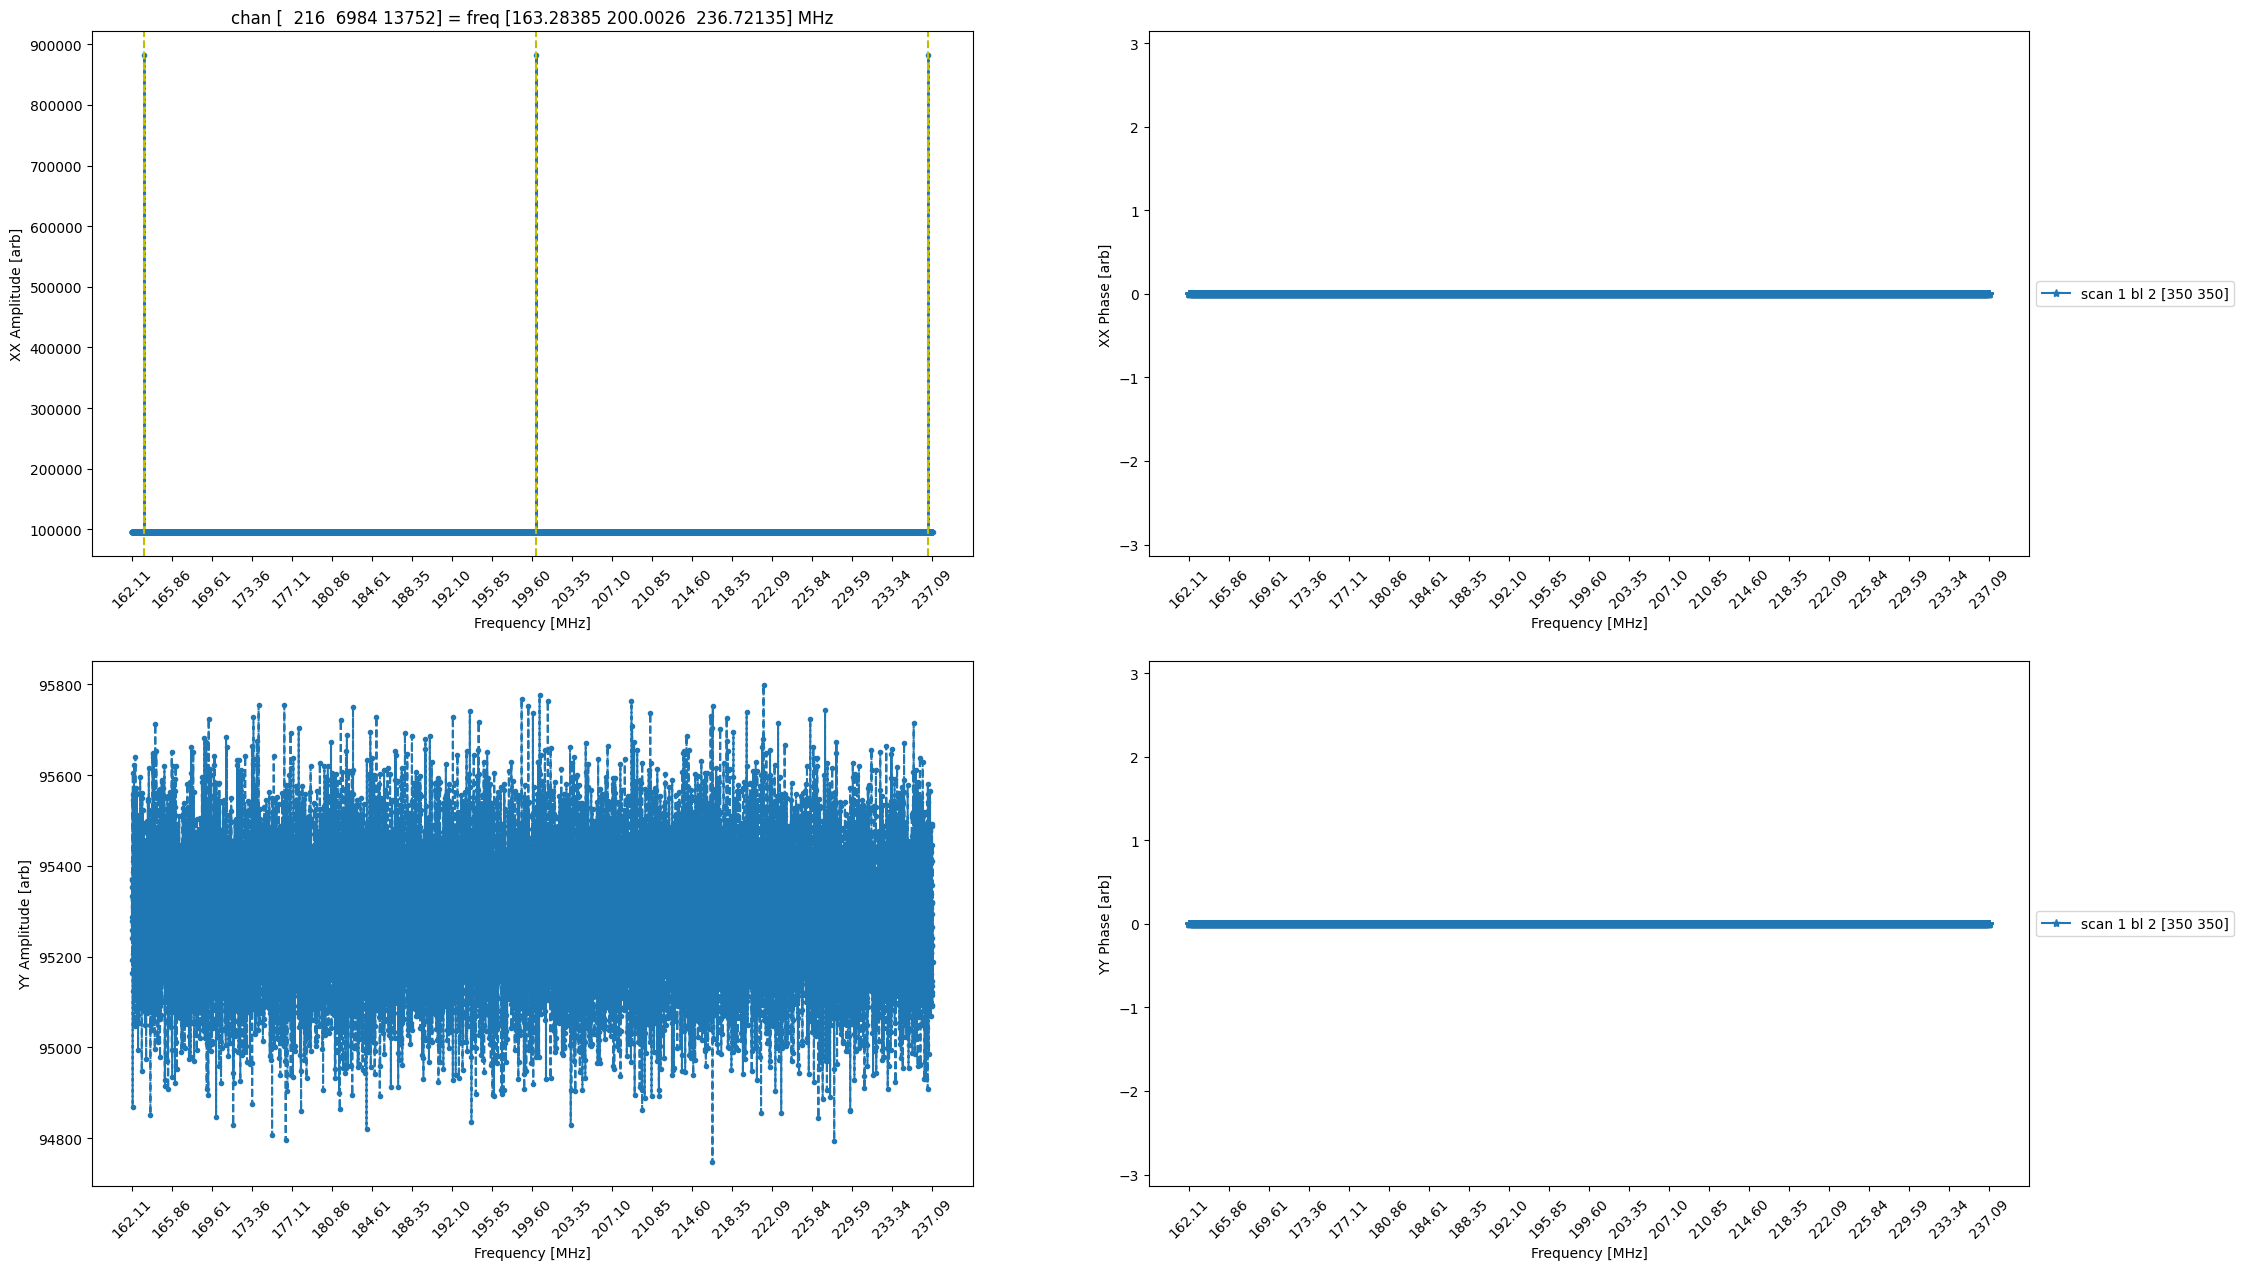

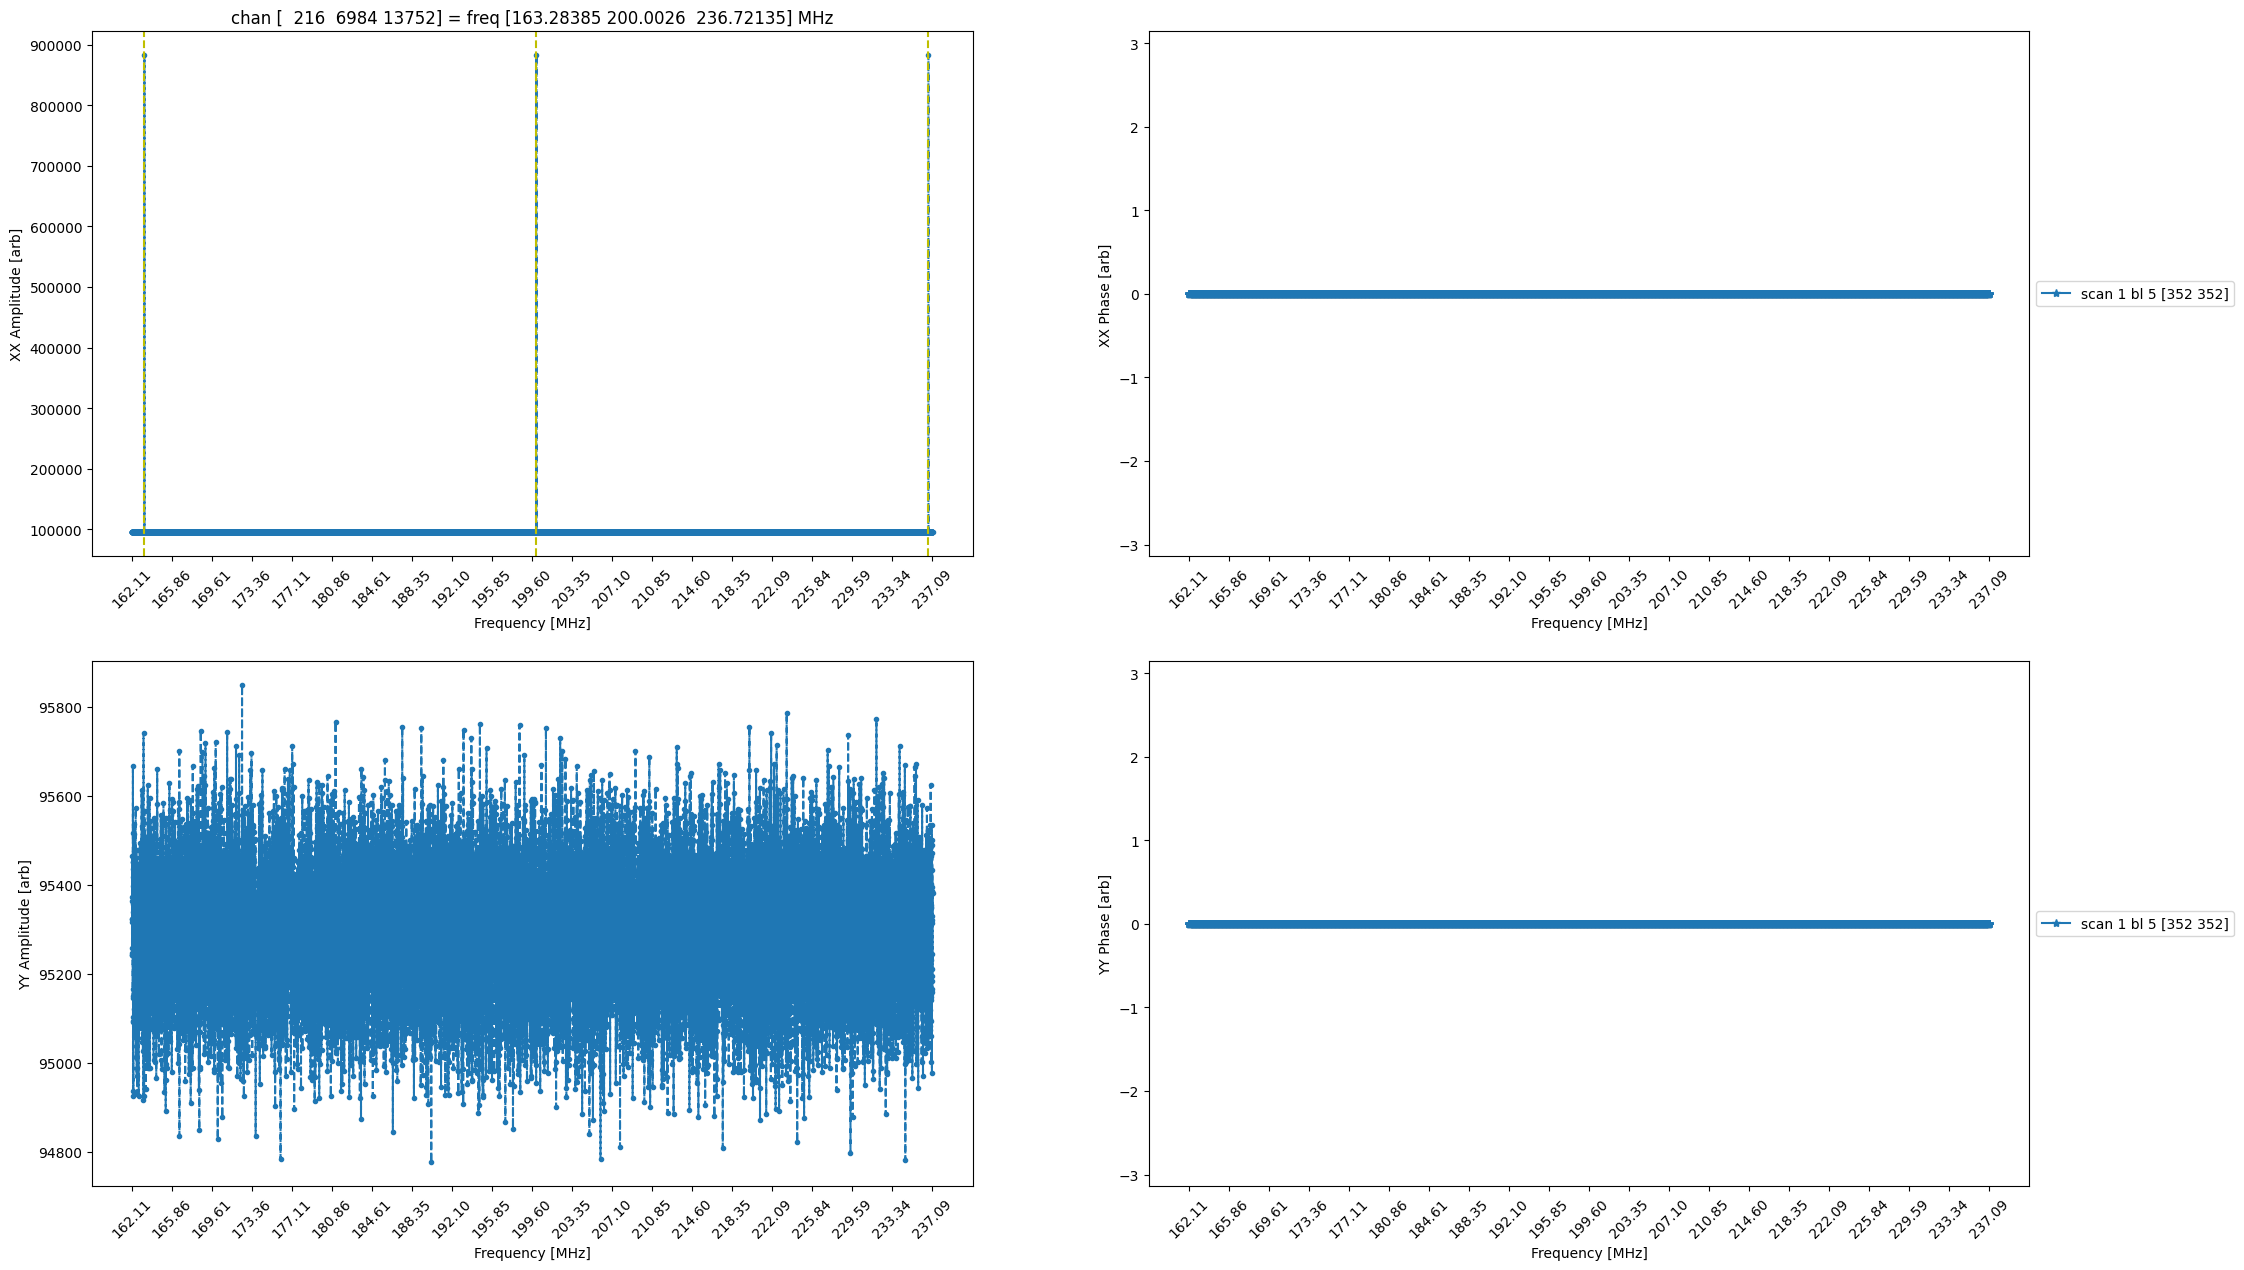

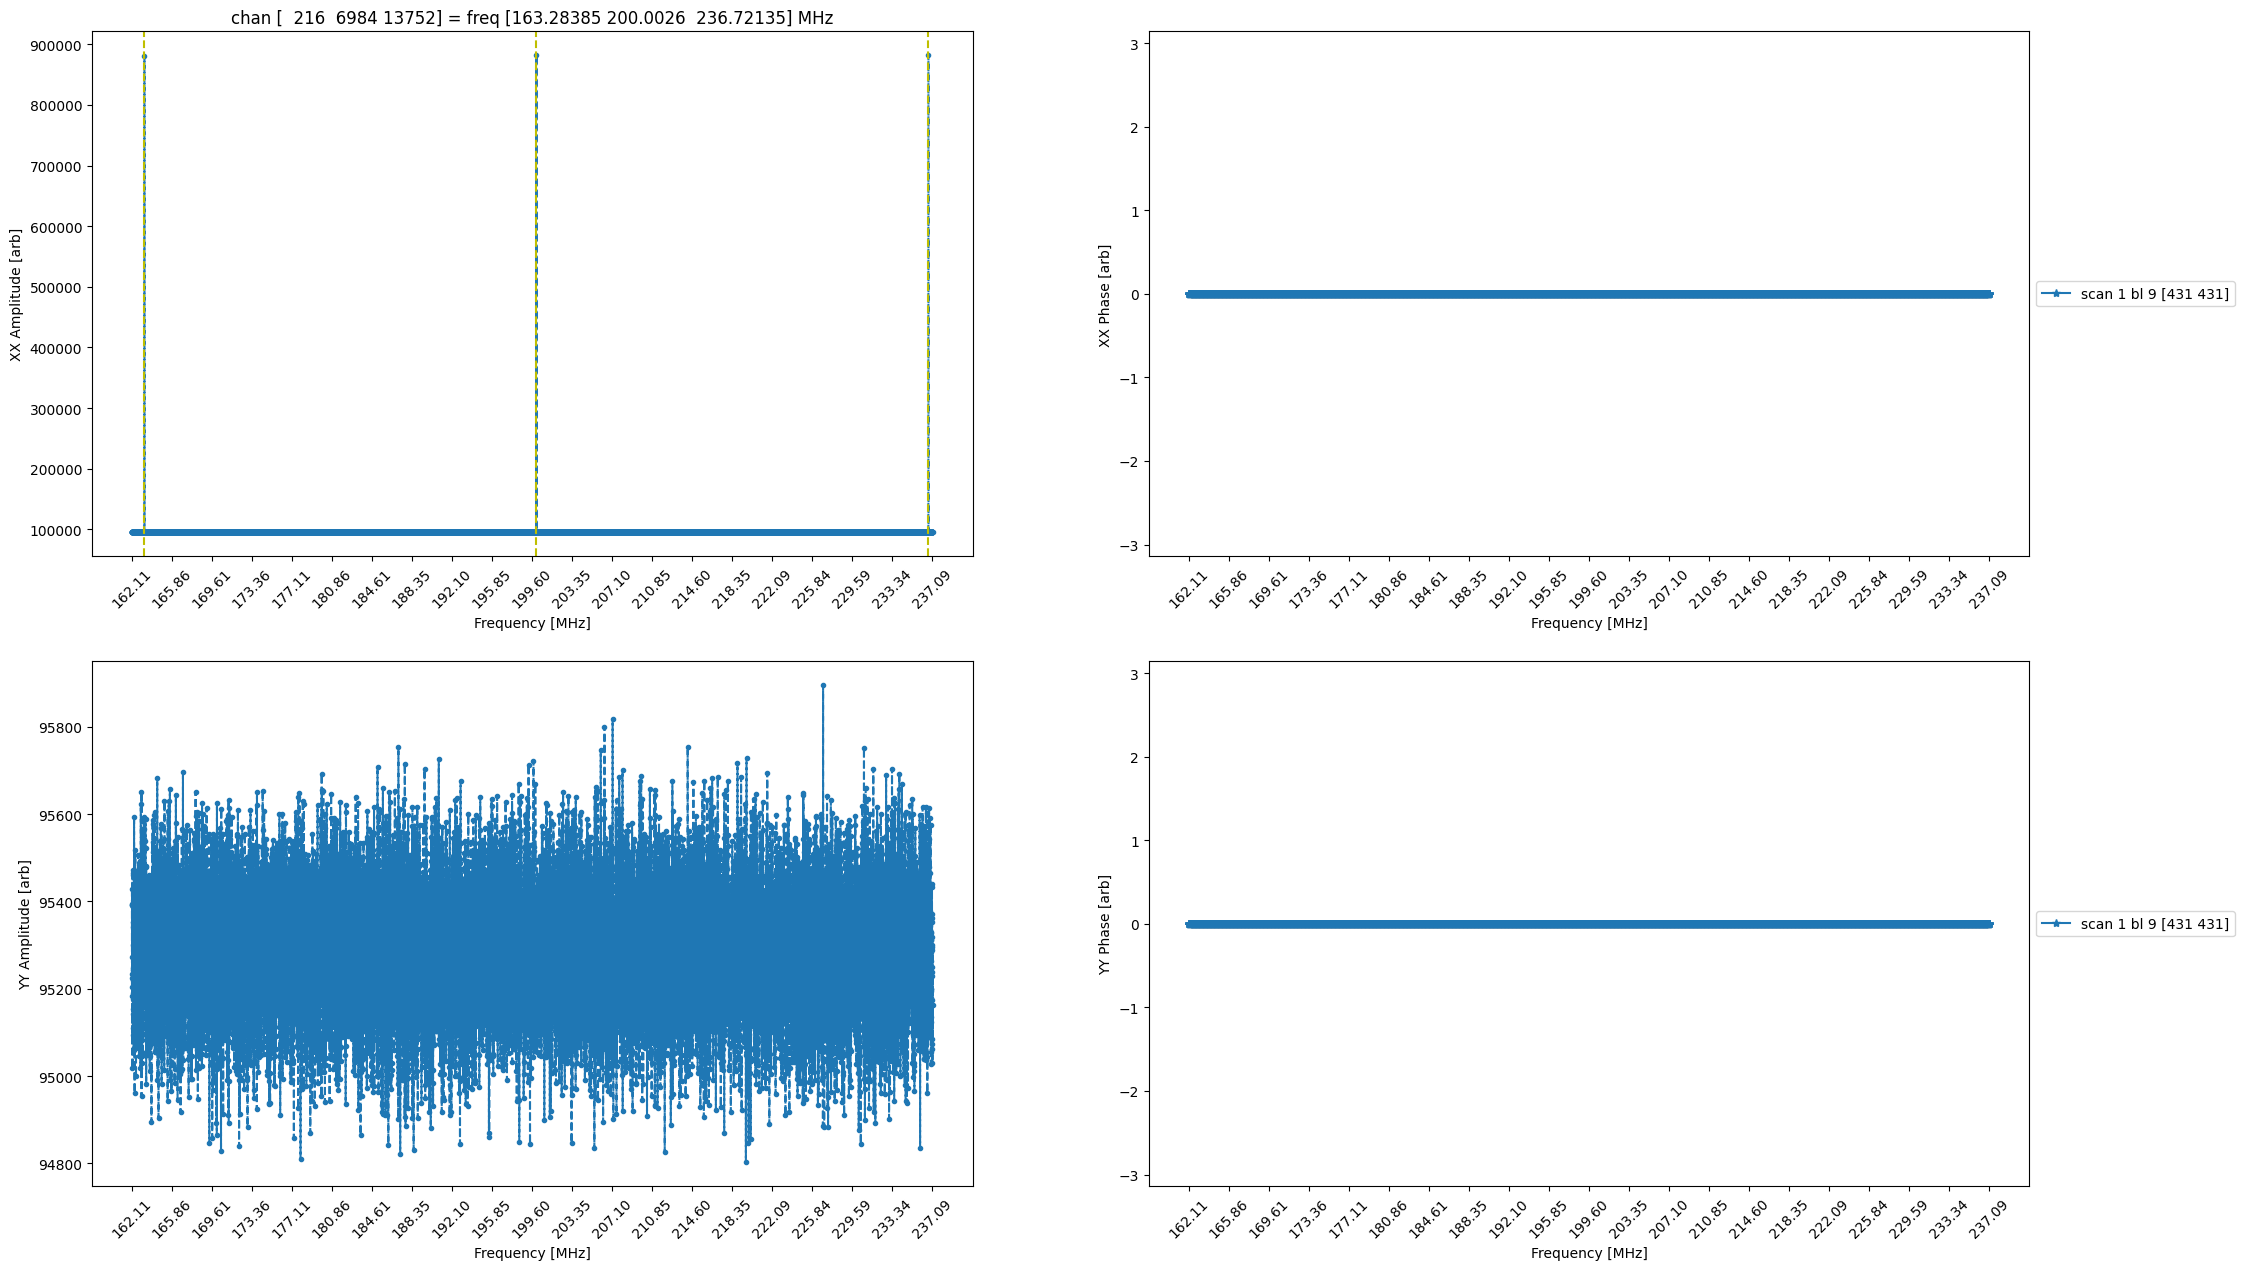

In [18]:
frequencies = pcap_output.metadata.FreHz.values/1e6
for scan_id in scan_ids:
    scan_samples = get_scan(VIS, scan_id)
    # show over all timestamps
    plot_over_channel(frequencies, np.nanmean(scan_samples.data, axis=0), scan_id, auto_corr_bls, bl_lookup) 